# Perform a thorough analysis and prediction of Microsoft stock

### Aim to find out:
1. The most impacting factors in each of the three datasets collected
2. Compare the performance of:
    * basic XGBoost models
    * advanced LSTMs
    * classical methods with facebook PROPHET2
3. The feasibility of prediction based on news sentiments alone
4. Find the most impactful news outlet - closest one to real prediction of the stock

### The final goal would be to create an automatic version that would go over all stocks and suggest the most profitable one

# Step1: Create the dataset to train on

## Pull all the data from alpha vantage

In [121]:
import requests
from pprint import pprint
import mplfinance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import calendar
import os
import logging
colors = sns.color_palette()
sns.set()
pd.set_option('display.max_colwidth',1000)

In [ ]:
# set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# create a file handler
handler = logging.FileHandler('msft_analysis.log')
handler.setLevel(logging.INFO)
# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(handler)

In [2]:
import string
import random

def get_data(parameters):
    endpoint = "https://www.alphavantage.co/query"
    for _ in range(100):
        parameters['apikey'] = ''.join(random.choices(string.ascii_uppercase + string.digits, k=15))
        # Send a GET request to the API endpoint
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            if 'Note' not in data: 
                break
            logger.warning(f'API key {parameters["apikey"]} has been used too many times. response note: {data["Note"]}')
            data = None
            time.sleep(1)
        else: 
            logger.error(f'API key {parameters["apikey"]} has returned an error. response note: {response.json()}')
    return data

### Get all prices up to 2 years ago

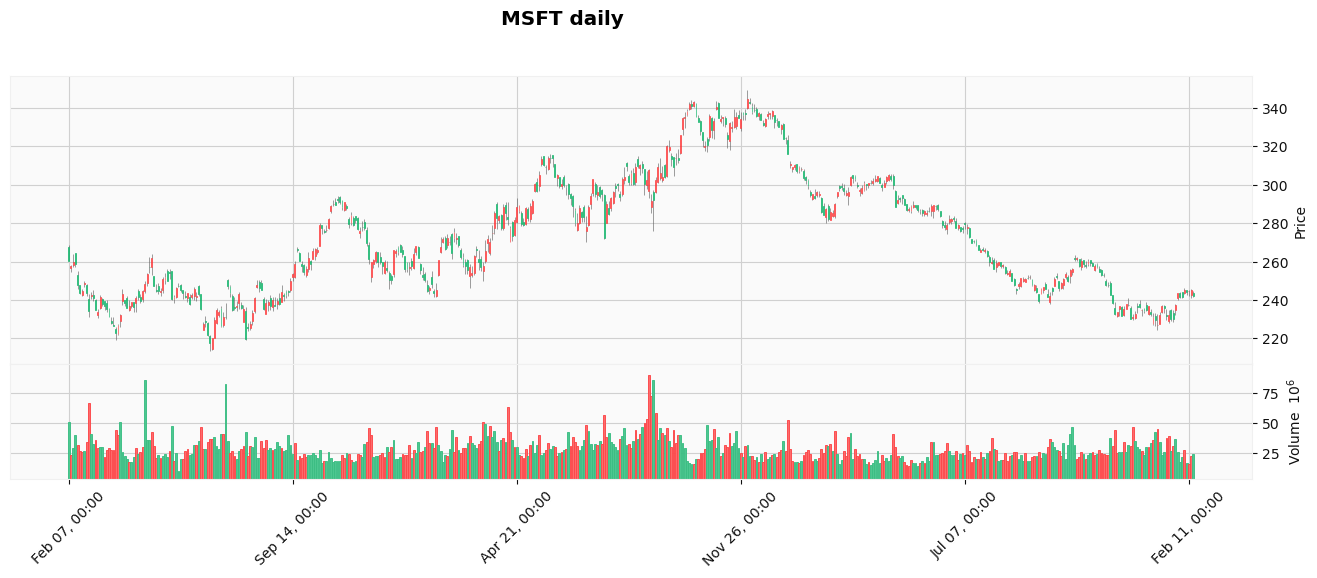

In [510]:
parameters = {
        "function": "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": 'MSFT',
        "outputsize": 'full'
    }
prices = get_data(parameters)
# convert to pandas dataframe
price_df = pd.DataFrame.from_dict(prices['Time Series (Daily)'], orient='index')
price_df.index = pd.to_datetime(price_df.index)
# take only the data up to 2 years ago and convert to numeric
price_df = price_df[price_df.index > datetime.now() - timedelta(days=365*2)].apply(pd.to_numeric)
# rename columns
price_df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount', 'split_coefficient']
# save to csv
price_df.to_csv('msft_prices.csv', index=True)
# create a candlestick plot
mplfinance.plot(price_df[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='MSFT daily', figratio=(15, 5))


### Get all weekly stock prices

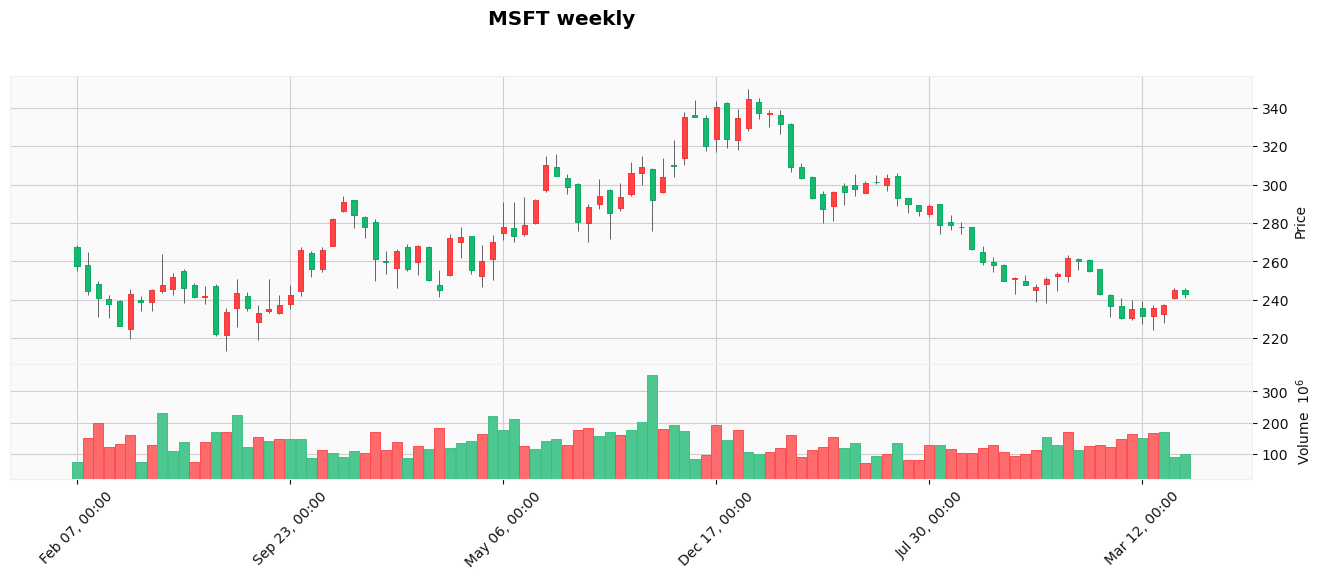

In [511]:
parameters = {
        "function": "TIME_SERIES_WEEKLY_ADJUSTED",
        "symbol": 'MSFT',
        "outputsize": 'full'
    }
prices = get_data(parameters)
# convert to pandas dataframe
price_df = pd.DataFrame.from_dict(prices['Weekly Adjusted Time Series'], orient='index')
price_df.index = pd.to_datetime(price_df.index)
# take only the data up to 2 years ago and convert to numeric
price_df = price_df[price_df.index > datetime.now() - timedelta(days=365*2)].apply(pd.to_numeric)
# rename columns
price_df.columns = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount']
# save to csv
price_df.to_csv('msft_weekly_prices.csv', index=True)
# create a candlestick plot
mplfinance.plot(price_df[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='MSFT weekly', figratio=(15, 5))


### get all the company's financial sheets

Pull all financial sheets from alpha vantage

In [512]:
functions = ['OVERVIEW', 'INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW', 'EARNINGS']
overviews = [get_data({"function": function, "symbol": 'MSFT', "horizon": "12month"}) for function in functions]
# save to json in a different directory
os.makedirs('msft_data', exist_ok=True)
for overview, function in zip(overviews, functions):
    with open(f'msft_data/msft_{function.lower()}.json', 'w') as outfile:
        json.dump(overview, outfile, indent=4)

Create the overview dataframe

In [513]:
def convert_overview_to_dataframe(overview):
    keys = []
    cols = []
    for key, val in overview.items():
        try:
            cols.append(float(val))
            if key not in keys: keys.append(key)
        # create an exception when the value is not a number
        except ValueError:
            try:
                cols.append(datetime.strptime(val, '%Y-%m-%d'))
                if key not in keys: keys.append(key)
            except ValueError:
                pass
    # return keys, cols
    return pd.DataFrame([cols], columns=keys)

overview_df = convert_overview_to_dataframe(overviews[0])
overview_df.to_csv('msft_overview.csv', index=False)
overview_df

,CIK,LatestQuarter,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
0,789019.0,2022-12-31,1.991663e+12,9.794500e+10,29.73,2.275,24.59,2.6,0.0106,9.0,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15


Create the earnings dataframe

In [514]:
earnings_ds = pd.DataFrame.from_dict(overviews[4]['quarterlyEarnings'])
earnings_ds['fiscalDateEnding'] = pd.to_datetime(earnings_ds['fiscalDateEnding'])
earnings_ds['reportedDate'] = pd.to_datetime(earnings_ds['reportedDate'])
# take only up to 2 years ago
earnings_ds = earnings_ds[earnings_ds['fiscalDateEnding'] > datetime.now() - timedelta(days=365*2)]
# convert all columns to numeric except the first two
earnings_ds.iloc[:, 2:] = earnings_ds.iloc[:, 2:].apply(pd.to_numeric)
# save to csv
earnings_ds.to_csv('msft_earnings.csv', index=False)
earnings_ds

,fiscalDateEnding,reportedDate,reportedEPS,estimatedEPS,surprise,surprisePercentage
0,2022-12-31,2023-01-24,2.32,2.30,0.02,0.8696
1,2022-09-30,2022-10-25,2.35,2.30,0.05,2.1739
2,2022-06-30,2022-07-26,2.23,2.29,-0.06,-2.6201
3,2022-03-31,2022-04-26,2.22,2.19,0.03,1.3699
4,2021-12-31,2022-01-25,2.48,2.31,0.17,7.3593
5,2021-09-30,2021-10-26,2.27,2.08,0.19,9.1346
6,2021-06-30,2021-07-27,2.17,1.92,0.25,13.0208
7,2021-03-31,2021-04-27,2.03,1.78,0.25,14.0449


### Get all the news sentiments

Reload the previous dataset

In [515]:
try: 
    sent_df = pd.read_csv('msft_sentiments.csv').drop(columns=['Unnamed: 0'], errors='ignore')
except FileNotFoundError: 
    sent_df = pd.DataFrame()

Create a new dataframe from the saved jsons

In [516]:
rows = []
# get a list of all files in the sentiments folder
for news_file in tqdm(os.listdir('sentiments')):
    with open(os.path.join('sentiments', news_file)) as f:
        news = json.load(f)
    if 'feed' not in news: continue
    for article in news['feed']:
        # parse date time from YYYYMMDDTHHMM format to datetime object
        time_pub = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S')
        # find item in list of dictionaries that contains a value matching 'MSFT'
        msft_sent = [item for item in article['ticker_sentiment'] if item['ticker'] == 'MSFT'][0]
        rows.append([msft_sent['ticker_sentiment_score'], msft_sent['relevance_score'], time_pub, article['url']])
        
# new_df = pd.DataFrame(ordered_sentiments).sort_values(by='time', ascending=False)
new_df = pd.DataFrame(rows, columns=['sentiment', 'relevance', 'time', 'url'])
# parse out anything between https:// and / in the url or http:// and / in the url
new_df['site'] = new_df['url'].apply(lambda x: x.split('https://')[1].split('/')[0] if 'https' in x else x.split('http://')[1].split('/')[0])
new_df.drop(columns=['url'], inplace=True)
# create a dataframe from the list of dictionaries and add it to the existing dataframe
new_sent_df = pd.concat([new_df, sent_df], axis=0, ignore_index=True)

100%|██████████| 142/142 [00:00<00:00, 3736.90it/s]


Combine the two dataframes and save to csv

In [517]:
new_sent_df['sentiment'] = new_sent_df['sentiment'].astype(float)
new_sent_df['time'] = pd.to_datetime(new_sent_df['time'])
new_sent_df = new_sent_df.drop_duplicates(ignore_index=True).sort_values(by='time', ascending=False)
new_sent_df.reset_index(inplace=True, drop=True)
# save the dataframe to a csv file
new_sent_df.to_csv(f'msft_sentiments.csv', index=False)
new_sent_df

,sentiment,relevance,time,site
0,0.093853,0.047371,2023-02-08 13:00:14,www.scmp.com
1,-0.299148,0.065327,2023-02-08 12:51:00,www.cnn.com
2,-0.106790,0.382925,2023-02-08 12:49:00,www.wsj.com
3,0.224523,0.295867,2023-02-08 12:46:00,www.reuters.com
4,0.000000,0.511256,2023-02-08 12:39:00,www.business-standard.com
...,...,...,...,...
17225,-0.215272,0.09923,2022-03-02 08:00:00,www.axios.com
17226,-0.092053,0.079078,2022-03-02 03:06:42,www.scmp.com
17227,-0.092053,0.079078,2022-03-02 03:06:42,www.scmp.com
17228,0.050726,0.61084,2022-03-01 20:38:54,stocknews.com


## Combine all dataframes into a single dataset

Load the sentiment dataframe and average the daily sentiment

Text(0.5, 0, '')

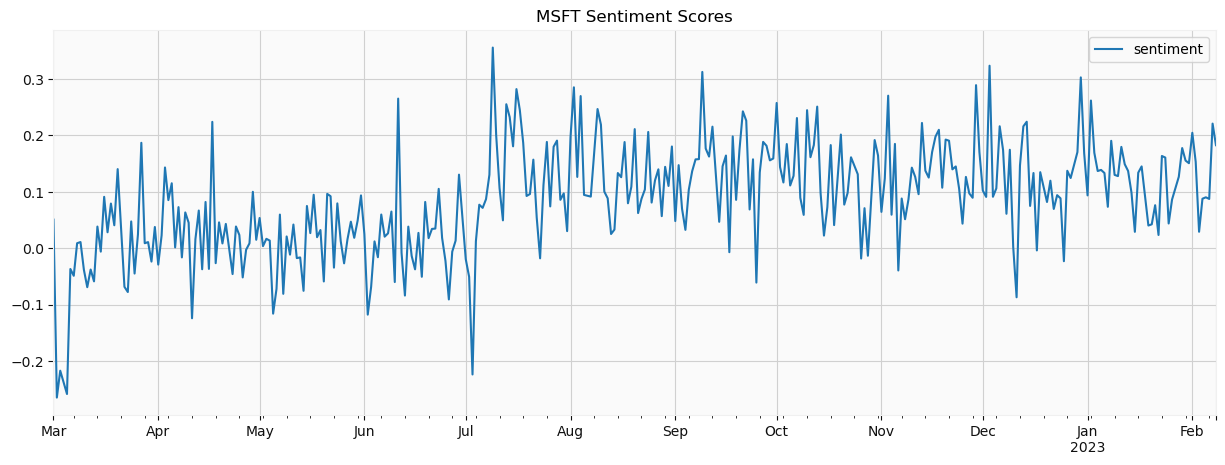

In [518]:
# read the csv file and convert the time column to datetime. ignore the index column
df = pd.read_csv('msft_sentiments.csv')
df['time'] = pd.to_datetime(df['time'])
# group the dataframe by day, average sentiment scores weighted by relevance
df = pd.DataFrame(df.groupby(pd.Grouper(key='time', freq='D')).apply(lambda x: np.average(x['sentiment'], weights=x['relevance'])), columns=['sentiment']).sort_index(ascending=False)
# # plot the sentiment scores
df.plot(figsize=(15, 5), title='MSFT Sentiment Scores', label='sentiment')
# # add a trendline to the plot
# mv_avg = 7
# df['trend'] = df['sentiment'].rolling(mv_avg).mean()
# df['trend'].plot(figsize=(15, 5), title='MSFT Sentiment Scores', label=f'{mv_avg} day moving average')
plt.xlabel('')
# plt.legend()
# df = df.drop(columns=['trend']).sort_index(ascending=False)

Load the daily price data and append it to the news dataset

In [519]:
prices_df = pd.read_csv('msft_weekly_prices.csv', index_col=0)
# sort the prices by date
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.sort_index(ascending=False, inplace=True)
df = df.join(prices_df, how='left').drop(columns=['split_coefficient', 'dividend_amount'], errors='ignore')
# normalize each of the columns between -1 and 1
# df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 2 - 1)
# for every nan value, replace it with the value of the previous day
df.fillna(method='ffill', inplace=True)
# normalize according to the mean and standard deviation
# new_df.iloc[:, 1:] = new_df.iloc[:, 1:].apply(lambda x: (x - x.mean()) / x.std())
# new_df = new_df.apply(lambda x: (x - x.mean()) / x.std())
df

,sentiment,open,high,low,close,adjusted_close,volume
time,,,,,,,
2023-02-08,0.182561,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07,0.220816,257.44,268.775,254.780,267.56,267.5600,73359362.0
2023-02-06,0.087376,257.44,268.775,254.780,267.56,267.5600,73359362.0
2023-02-05,0.090266,257.44,268.775,254.780,267.56,267.5600,73359362.0
2023-02-04,0.087724,257.44,268.775,254.780,267.56,267.5600,73359362.0
...,...,...,...,...,...,...,...
2022-03-05,-0.258166,288.53,289.690,270.000,280.07,278.0128,184358475.0
2022-03-04,-0.236631,294.31,303.130,287.165,289.86,287.7309,157402366.0
2022-03-03,-0.216885,294.31,303.130,287.165,289.86,287.7309,157402366.0


Plot everything while scaling the sentiments by a factor of 10

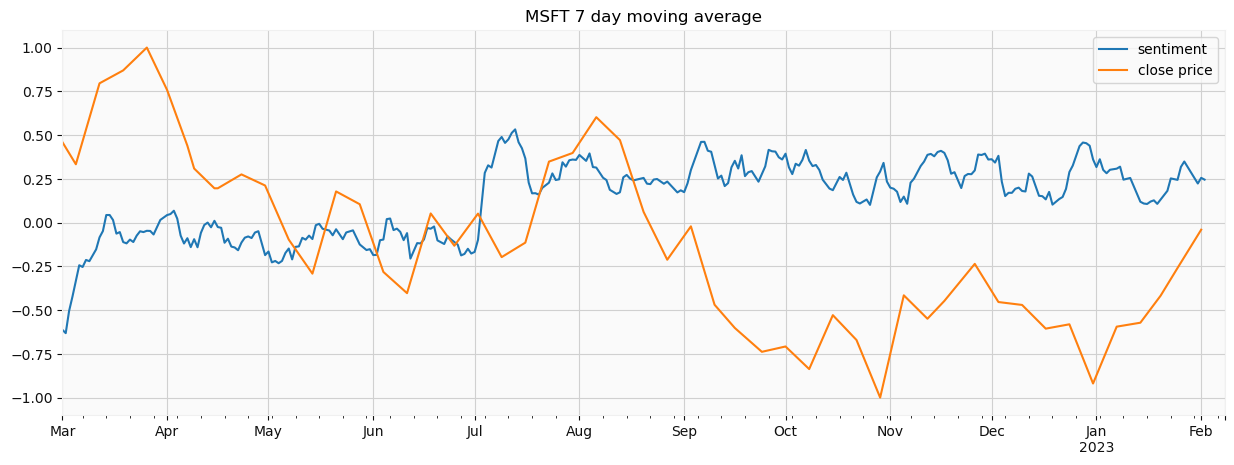

In [524]:
# plot the sentiment scores
mv_avg = 7
temp_df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 2 - 1)
# multiply the sentiment scores by 2 to make the trendline more visible
temp_df['sentiment'].rolling(mv_avg).mean().plot(figsize=(15, 5), title=f'MSFT {mv_avg} day moving average', label=f'sentiment')
# new_df['close'].plot(figsize=(15, 5), title='MSFT Sentiment Scores', label='close')
temp_df['close'].rolling(mv_avg).mean().plot(figsize=(15, 5), title=f'MSFT {mv_avg} day moving average', label=f'close price')
# add vertical lines to indicate 
# plt.axvline(x='2022-07-13', color='red', linestyle='--')
# plt.axvline(x='2022-08-12', color='black', linestyle='--')
plt.xlabel('')
plt.legend()

Load the overview dataframe and append it as well

In [525]:
overview_df = pd.read_csv('msft_overview.csv')
# convert any value that could be converted to a float to a float
overview_df = overview_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
# convert any value that could be converted to a datetime to a datetime except numeric values
overview_df = overview_df.apply(lambda x: pd.to_datetime(x, errors='ignore') if x.dtype != 'float64' else x)
new_df = df.copy()
for col in overview_df.columns:
    new_df[col] = overview_df[col][0]
new_df.to_csv('msft_weekly_dataset.csv')
new_df

,sentiment,open,high,low,close,adjusted_close,volume,CIK,LatestQuarter,MarketCapitalization,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
time,,,,,,,,,,,,,,,,,,,,,
2023-02-08,0.182561,NaN,NaN,NaN,NaN,NaN,NaN,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-07,0.220816,257.44,268.775,254.780,267.56,267.5600,73359362.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-06,0.087376,257.44,268.775,254.780,267.56,267.5600,73359362.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-05,0.090266,257.44,268.775,254.780,267.56,267.5600,73359362.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2023-02-04,0.087724,257.44,268.775,254.780,267.56,267.5600,73359362.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-05,-0.258166,288.53,289.690,270.000,280.07,278.0128,184358475.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2022-03-04,-0.236631,294.31,303.130,287.165,289.86,287.7309,157402366.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15
2022-03-03,-0.216885,294.31,303.130,287.165,289.86,287.7309,157402366.0,789019.0,2022-12-31,1.991663e+12,...,9.21,18.55,0.916,313.66,212.83,243.78,253.95,7.443800e+09,2023-03-09,2023-02-15


<span style="color:red">TODO Also add the earnings dataset</span>

# Step 2: Run in XGBoost and define the most impacting features

### <span style="color:red">TODO make it predict the weekly price instead. And feed it volume, high, and low of the previous days (move every item to be a day backward when feeding)</span>

In [646]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# import minmaxscaler
# from sklearn.preprocessing import MinMaxScaler

## Split to train and test data

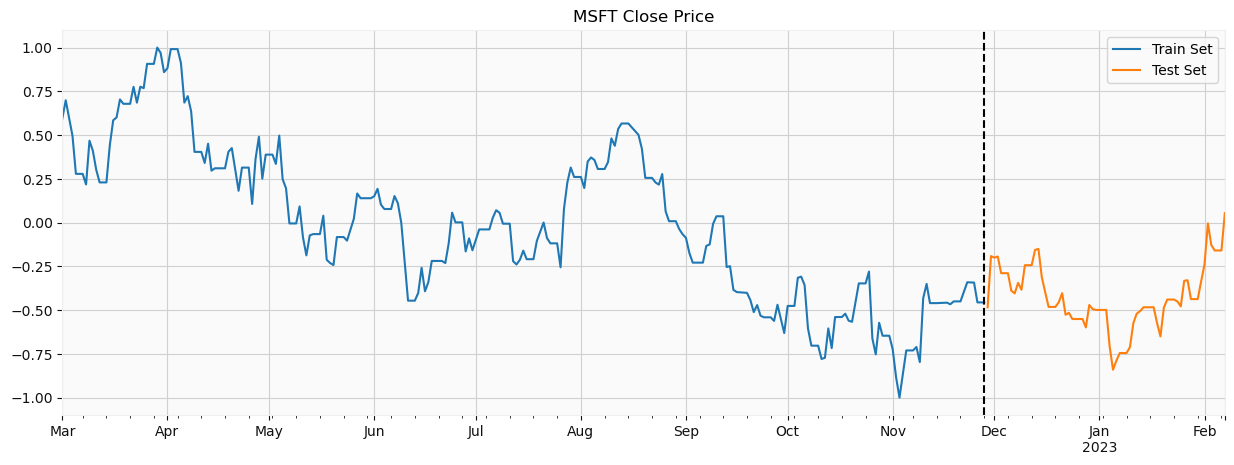

In [647]:
df = pd.read_csv('msft_dataset.csv', index_col=0)
# df = pd.read_csv('msft_weekly_dataset.csv', index_col=0)

df.index = pd.to_datetime(df.index)
df.sort_index(ascending=False, inplace=True)
# drop any column that contains a date time value
df = df.drop(columns=[col for col in df.columns if df[col].dtype != 'float64']).dropna()
# scale up sentiment scores to be the same magnitude as the close price
# df['sentiment'] = df['sentiment'] * 100
# normalize values
df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) * 2 - 1)
# also drop any values that could contribute to overfitting
df = df.drop(columns=['adjusted_close', 'high', 'low'])
# drop any columns that contain nan values
df = df.dropna(axis=1)
# get all times before the last month
train_df, test_df = df[df.index < df.index.max() - pd.DateOffset(weeks=10)], df[df.index >= df.index.max() - pd.DateOffset(weeks=10)]
# plot both the training and testing data
train_df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Train Set')
test_df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Test Set')
# add vertical lines to indicate the separation between the training and testing data
plt.axvline(x=train_df.index[0], color='black', linestyle='--')
plt.xlabel('')
plt.legend()

## create a xgboost regression
The model will be trained twice for comparison - with and without sentiment to see its impact

In [648]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=200, eval_metric='rmse', learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
reg_no_sent = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=200, eval_metric='rmse', learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

X_train, y_train = train_df.drop(columns=['close']), train_df['close']
X_test, y_test = test_df.drop(columns=['close']), test_df['close']

x_no_sent_train = X_train.drop(columns=['sentiment'])
x_no_sent_test = X_test.drop(columns=['sentiment'])

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
reg_no_sent.fit(x_no_sent_train, y_train, eval_set=[(x_no_sent_train, y_train), (x_no_sent_test, y_test)], verbose=True)
print('done')

[0]	validation_0-rmse:0.60943	validation_1-rmse:0.85022
[1]	validation_0-rmse:0.55212	validation_1-rmse:0.76766
[2]	validation_0-rmse:0.51415	validation_1-rmse:0.72125
[3]	validation_0-rmse:0.46573	validation_1-rmse:0.65337
[4]	validation_0-rmse:0.42267	validation_1-rmse:0.59096
[5]	validation_0-rmse:0.38329	validation_1-rmse:0.53565
[6]	validation_0-rmse:0.36025	validation_1-rmse:0.50845
[7]	validation_0-rmse:0.33714	validation_1-rmse:0.48324
[8]	validation_0-rmse:0.31869	validation_1-rmse:0.46112
[9]	validation_0-rmse:0.28943	validation_1-rmse:0.41995
[10]	validation_0-rmse:0.26338	validation_1-rmse:0.38232
[11]	validation_0-rmse:0.24791	validation_1-rmse:0.36398
[12]	validation_0-rmse:0.22602	validation_1-rmse:0.33354
[13]	validation_0-rmse:0.20636	validation_1-rmse:0.30504
[14]	validation_0-rmse:0.19548	validation_1-rmse:0.29163
[15]	validation_0-rmse:0.17884	validation_1-rmse:0.26756
[16]	validation_0-rmse:0.17024	validation_1-rmse:0.26020
[17]	validation_0-rmse:0.15619	validation

<AxesSubplot:title={'center':'Feature Importance'}>

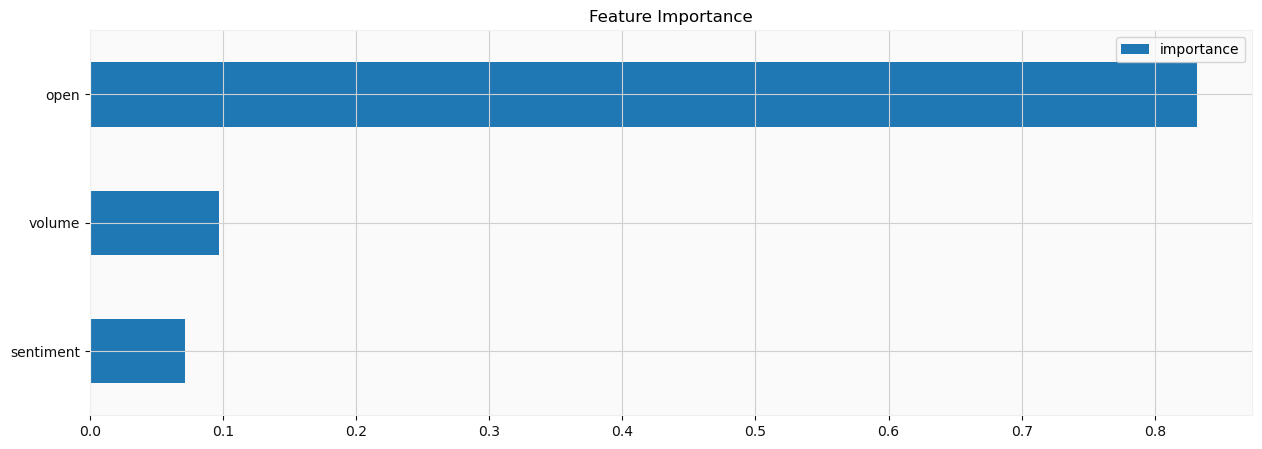

In [649]:
fi = pd.DataFrame(reg.feature_importances_[:5], index=reg.feature_names_in_[:5], columns=['importance']).sort_values(by='importance')
fi.plot(kind='barh', figsize=(15, 5), title='Feature Importance')

## Forecast on Test

In [650]:
X_test['prediction'] = reg.predict(X_test)
x_no_sent_test['prediction'] = reg_no_sent.predict(x_no_sent_test)
df = df.copy().merge(X_test[['prediction']], how='left', left_index=True, right_index=True)
# df_no_sent = df.copy().merge(x_no_sent_test[['prediction']], how='left', left_index=True, right_index=True)

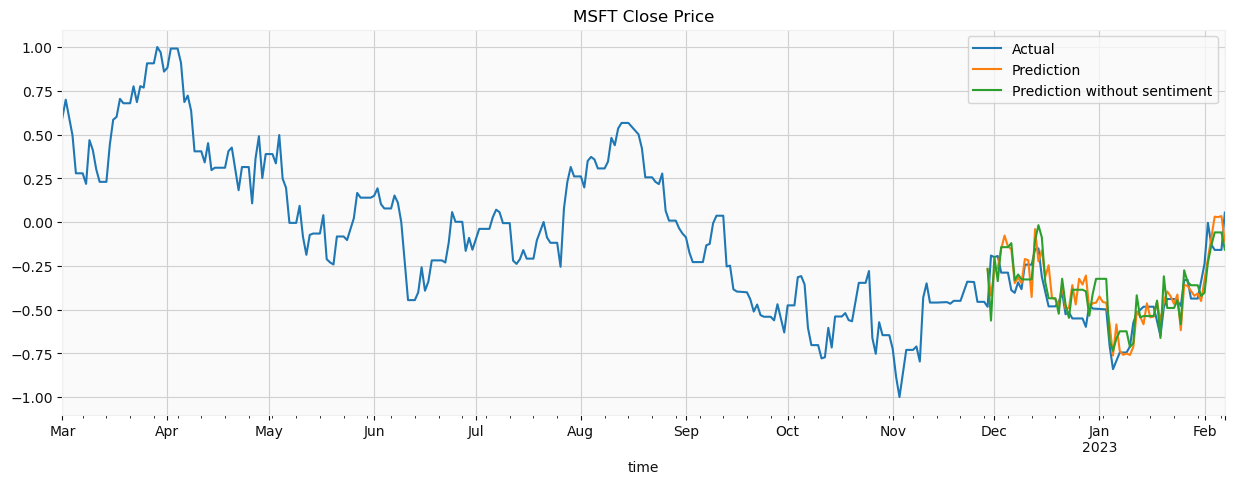

In [651]:
df['close'].plot(figsize=(15, 5), title='MSFT Close Price', label='Actual')
df['prediction'].plot(figsize=(15, 5), title='MSFT Close Price', label='Prediction')
x_no_sent_test['prediction'].plot(figsize=(15, 5), title='MSFT Close Price', label='Prediction without sentiment')
# plot the prediction once every 7 days
# df['prediction'].iloc[::7].plot(figsize=(15, 5), title='MSFT Close Price', label='smoothed Prediction')
plt.legend()

Print out the root mean squared error

In [655]:
score = np.sqrt(mean_squared_error(y_test, X_test['prediction']))
score_no_sent = np.sqrt(mean_squared_error(y_test, x_no_sent_test['prediction']))
print(f'RMSE: {score:.4f}, RMSE without sentiment: {score_no_sent:.4f}')

RMSE: 0.1188, RMSE without sentiment: 0.1248


The worst predictions without sentiment:

In [656]:
X_test['error'] = np.abs(X_test['prediction'] - y_test)
X_test['date'] = X_test.index
print(X_test.groupby(['date']).mean().sort_values(ascending=False, by='error')['error'].head())

date
2022-12-28    0.293372
2022-12-17    0.234813
2022-12-06    0.234282
2023-02-02    0.230846
2022-11-30    0.229064
Name: error, dtype: float64


The worst predictions without sentiments

In [ ]:
x_no_sent_test['error'] = np.abs(x_no_sent_test['prediction'] - y_test)
x_no_sent_test['date'] = x_no_sent_test.index
print(x_no_sent_test.groupby(['date']).mean().sort_values(ascending=False, by='error')['error'].head())

# Next steps
- find out how to milk your other features better - instead of just dropping volume, make it delayed by one day/week - same for min and high
- Create more robust cross validation
- Move to predicting weekly data. maintain the mean across the weekly sentiment as well - the model is currently making daily predictions still
- switch to a model of only predicting sentiment towards stock: bullish, somwhat bullish, bearish, somwhat bearish, neutral, somwhat neutral